## 프로젝트 - 한영 번역기 만들기
### Seq2Seq Translation
***
#### Step 1. 데이터 가져오기

#### Step 2. 데이터 정제
1) set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.  

2) 앞서 정의한 preprocessing() 함수는 한글에 대해 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!  

3) 타겟 언어인 영문엔 \<start> 토큰과 \<end> 토큰을 추가하고 split() 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.  

4) 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

#### Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)  

#### Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!  

#### Step 5. 훈련하기

***
### 평가문항
**1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.**  
-구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.  

**2. Attentional Seq2seq 모델이 정상적으로 구동된다.**  
-seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.    

**3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.**  
-테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.  
***
#### Step 1. 데이터 가져오기
***
**-데이터 확인해보기**

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

-데이터를 확인하기 전에 라이브러리의 기본폰트가 한국어를 지원하지 않기 때문에 한국어 폰트를 가져옵니다.

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from konlpy.tag import Mecab
mecab = Mecab()

from tqdm import tqdm
import random

-프로젝트를 위한 기본적인 라이브러리를 import해줍니다.

In [3]:
kor = os.getenv('HOME')+'/aiffel/s2s_translation/data/korean-english-park.train.ko'
eng = os.getenv('HOME')+'/aiffel/s2s_translation/data/korean-english-park.train.en'

-노드에서의 실습처럼 pair가 합쳐진 데이터가 아니므로 각각을 나눠서 가져옵니다.

In [4]:
with open(kor,"r") as f:
    ko_raw = f.read().splitlines()
    
with open(eng,"r") as f:
    en_raw = f.read().splitlines()

In [5]:
print("Kor Data Size :",len(ko_raw))
print("Eng Data Size :",len(en_raw))

Kor Data Size : 94123
Eng Data Size : 94123


-총 94123쌍의 데이터입니다.  
-각각의 데이터를 확인해보겠습니다.

In [6]:
print("Kor Data Example :")
for sen in ko_raw[0:100][::20]:print(">>",sen)

Kor Data Example :
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [7]:
print("Eng Data Example :")
for sen in en_raw[0:100][::20]:print(">>",sen)

Eng Data Example :
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


-각각이 쌍을 이루는것을 확인할 수 있습니다.
***
#### Step 2. 데이터 정제
**1) set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.**  

In [8]:
cleaned_corpus = list(set(zip(ko_raw, en_raw)))

In [9]:
print("Clean corpus :",len(cleaned_corpus))

Clean corpus : 78968


-한국어 데이터와 영어 데이터를 각각 중복제어했을 경우 병렬 쌍이 흐트러지는 것을 확인하였습니다.  
-동일한 개수로 이루어진 자료형을 묶어주는 zip함수를 활용하여 병렬 쌍을 유지하고 중복을 제거하여 주었습니다.  

In [10]:
print(cleaned_corpus[7])

('이타르타스 통신에따르면 펜자 관할 검사는 “쿠즈네트소브가 조사를 받고 있다”고 말했다.', 'Kuznetsov, 43, is "under the supervision of investigators," Olig Troshin, a Penza prosecutor, told Itar-Tass.')


**2) 앞서 정의한 preprocessing() 함수는 한글에 대해 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!**  

In [11]:
def kor_preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    # 영어의 경우 대문자가 있어 다른 단어로 인식할 수 있으니 이를 소문자로 변경해줍니다.

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # ?.!,를 제외한 특수문자 제외
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 띄어쓰기가 중복되었을 때 하나의 띄어쓰기로 대체
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)
    # ^a-zA-Z?.!, 를 제외한 문자를 띄어쓰기로 대체

    sentence = sentence.strip()
    # 문장의 양쪽 공백을 제거합니다.
    sentence = mecab.morphs(sentence)
    # 한국어 말뭉치를 만들기 위해 mecab을 활용합니다.

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

**3) 타겟 언어인 영문엔 \<start> 토큰과 \<end> 토큰을 추가하고 split() 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.**  

In [12]:
def eng_preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    # 영어의 경우 대문자가 있어 다른 단어로 인식할 수 있으니 이를 소문자로 변경해줍니다.

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # ?.!,를 제외한 특수문자 제외
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 띄어쓰기가 중복되었을 때 하나의 띄어쓰기로 대체
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    # ^a-zA-Z?.!, 를 제외한 문자를 띄어쓰기로 대체

    sentence = sentence.strip()
    # 문장의 양쪽 공백을 제거합니다.

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
        
    sentence = sentence.split()
    # 한국어와 다르게 영어는 split으로 충분합니다.
    
    return sentence

In [13]:
ko_raw_corpus = []
en_raw_corpus = []

for kor, eng in cleaned_corpus:
    ko_raw_corpus.append(kor_preprocess_sentence(kor))
    en_raw_corpus.append(eng_preprocess_sentence(eng,s_token=True,e_token=True))

In [14]:
print(ko_raw_corpus[7])
print(en_raw_corpus[7])

['이타르타스', '통신', '에', '따르', '면', '펜자', '관할', '검사', '는', '쿠즈', '네트', '소', '브', '가', '조사', '를', '받', '고', '있', '다', '고', '말', '했', '다', '.']
['<start>', 'kuznetsov', ',', ',', 'is', 'under', 'the', 'supervision', 'of', 'investigators', ',', 'olig', 'troshin', ',', 'a', 'penza', 'prosecutor', ',', 'told', 'itar', 'tass', '.', '<end>']


In [15]:
print(len(ko_raw_corpus[7]))

25


-길이조절을 하지 않은 한국어 말뭉치와 영어 말뭉치가 완성되었다.

**4) 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.**

-학습을 위해서는 pair를 유지해야하기 때문에 위의 zip함수를 활용하여 한국어 데이터의 갯수에 맞게 구축해보겠다.

In [16]:
before_corpus = list(zip(ko_raw_corpus, en_raw_corpus))

In [17]:
print(before_corpus[7])

(['이타르타스', '통신', '에', '따르', '면', '펜자', '관할', '검사', '는', '쿠즈', '네트', '소', '브', '가', '조사', '를', '받', '고', '있', '다', '고', '말', '했', '다', '.'], ['<start>', 'kuznetsov', ',', ',', 'is', 'under', 'the', 'supervision', 'of', 'investigators', ',', 'olig', 'troshin', ',', 'a', 'penza', 'prosecutor', ',', 'told', 'itar', 'tass', '.', '<end>'])


In [18]:
print(len(before_corpus))

78968


In [19]:
def length_limit(corpus, max_length = 20):
    kor_corpus = []
    eng_corpus = []
    for i in range(len(corpus)):
        if len(corpus[i][0]) <= max_length:
            kor_corpus.append(corpus[i][0])
            eng_corpus.append(corpus[i][1])
    
    return kor_corpus, eng_corpus

In [20]:
kor_corpus, eng_corpus = length_limit(before_corpus)

In [21]:
len(kor_corpus), len(eng_corpus)

(20279, 20279)

-pair를 이루도록 토큰의 길이를 잘 조절해 주었다.
***
#### Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

In [22]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [23]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus)
eng_tensor, eng_tokenizer = tokenize(eng_corpus)

print("korean Vocab Size:", len(kor_tokenizer.index_word))
print("english Vocab Size:", len(eng_tokenizer.index_word))

korean Vocab Size: 22535
english Vocab Size: 19745


-토큰화가 잘 이루어진 것을 확인하였다.
***
#### Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!  

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [27]:
BATCH_SIZE     = 128
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 512
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (128, 30, 512)
Decoder Output: (128, 19746)
Decoder Hidden State: (128, 512)
Attention: (128, 30, 1)


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [29]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

#### Step 5. 훈련하기

In [30]:
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 20: 100%|██████████| 159/159 [01:09<00:00,  2.30it/s, Loss 1.5677]


In [31]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = kor_preprocess_sentence(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


In [32]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [33]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split())

Input: ['라디오', '에서', '는', '오바마', '가', '대통령', '이', '라고', '말', '했', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


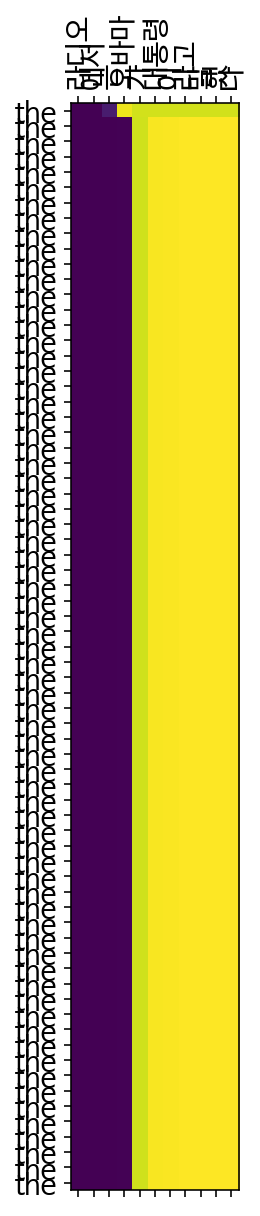

In [34]:
translate("라디오에서는 오바마가 대통령이라고 말했다", encoder, decoder)

Input: ['아프간', '에서', '공격', '이', '증가', '했', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


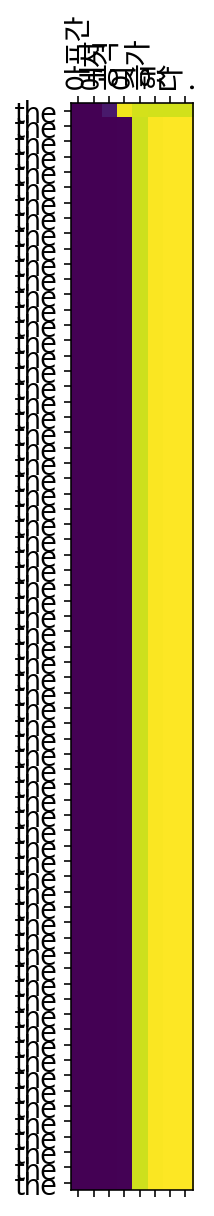

In [35]:
translate("아프간에서 공격이 증가했다.", encoder, decoder)

#### 회고록  
결과가 처참하다. 하이퍼파라미터를 좀 조정하고 싶었는데 좀 늘릴려고하면 커널이 죽어서 최소한으로 줄일 수 밖에 없었다.  
토큰길이도 40으로 정해서 진행할 수 있었지만 커널이 계속 죽어서 점점 줄이다 결국 반인 20으로 정할 수 밖에 없었다.  
최적의 하이퍼 파라미터를 찾고싶었지만 컴퓨팅파워에서의 한계로 인해 진행할 수가 없었다.  
좀 더 좋은 조건이라면 가능할 수도 있을 것 같다.  
아니면 내가 최적의 파라미터를 찾지못해서 그랬을 수도 있다.  
뭔가 편안하게 마무리 지을 줄 알았는데 아니라서 씁쓸했다.